In [1]:
import numpy as np 
import pandas as pd 
import FinanceDataReader as fdr
import matplotlib.pyplot as plt 

import datetime 

import torch 
import torch.nn as nn 
from torch.autograd import Variable 

import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

In [3]:
df = fdr.DataReader('KS11','2000')
df['Close'].plot()

<AxesSubplot:xlabel='Date'>

In [4]:
X = df.drop(columns=['Volume','Change'])
y = df.iloc[:, 5:6]

print(X)
print(y)

              Close     Open     High      Low
Date                                          
2000-01-04  1059.04  1028.33  1066.18  1016.59
2000-01-05   986.31  1006.87  1026.52   984.05
2000-01-06   960.79  1013.95  1014.90   953.50
2000-01-07   948.65   949.17   970.16   930.84
2000-01-10   987.24   979.67   994.94   965.02
...             ...      ...      ...      ...
2021-10-05  2962.17  2998.17  2998.17  2940.59
2021-10-06  2908.31  2986.06  2993.47  2908.30
2021-10-07  2959.46  2936.87  2961.53  2927.60
2021-10-08  2956.30  2977.82  2978.08  2949.01
2021-10-12  2916.38  2950.22  2950.94  2901.51

[5376 rows x 4 columns]
            Change
Date              
2000-01-04  0.0301
2000-01-05 -0.0687
2000-01-06 -0.0259
2000-01-07 -0.0126
2000-01-10  0.0407
...            ...
2021-10-05 -0.0189
2021-10-06 -0.0182
2021-10-07  0.0176
2021-10-08 -0.0011
2021-10-12 -0.0135

[5376 rows x 1 columns]


In [5]:
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70): int(len(df))])

print(data_training.shape)
print(data_testing.shape)

(3763, 1)
(1613, 1)


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [8]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.33534826],
       [0.29402909],
       [0.27953074],
       ...,
       [0.88608681],
       [0.89144984],
       [0.89108056]])

In [9]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)  

In [10]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [11]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'tanh', return_sequences = True,
              input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'tanh', return_sequences = True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'tanh', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'tanh'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 60)           26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 60)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 80)           45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 80)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [13]:
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics ='mae')
history = model.fit(x_train, y_train,
                    epochs = 50,batch_size=32)

Epoch 1/50
115/115 [==============================] - 15s 97ms/step - loss: 0.0180 - mae: 0.0872
Epoch 2/50
115/115 [==============================] - 11s 96ms/step - loss: 0.0069 - mae: 0.0602
Epoch 3/50
115/115 [==============================] - 11s 96ms/step - loss: 0.0058 - mae: 0.0550
Epoch 4/50
115/115 [==============================] - 11s 96ms/step - loss: 0.0049 - mae: 0.0509
Epoch 5/50
115/115 [==============================] - 11s 96ms/step - loss: 0.0048 - mae: 0.0502
Epoch 6/50
115/115 [==============================] - 11s 95ms/step - loss: 0.0050 - mae: 0.0514
Epoch 7/50
115/115 [==============================] - 11s 97ms/step - loss: 0.0041 - mae: 0.0462
Epoch 8/50
115/115 [==============================] - 11s 96ms/step - loss: 0.0043 - mae: 0.0481
Epoch 9/50
115/115 [==============================] - 11s 96ms/step - loss: 0.0038 - mae: 0.0449
Epoch 10/50
115/115 [==============================] - 11s 95ms/step - loss: 0.0037 - mae: 0.0443
Epoch 11/50
115/115 [========

In [14]:
model.save('LSTM_model.h5')

In [15]:
past_100_days = data_training.tail(100)

In [17]:
final_df = past_100_days.append(data_testing, ignore_index=True)

In [18]:
input_data = scaler.fit_transform(final_df)

In [19]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])

In [20]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(1613, 100, 1)
(1613,)


In [21]:
y_predicted = model.predict(x_test)

In [22]:
scaler.scale_

array([0.00054125])

In [23]:
scale_factor = 1/0.00042257
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

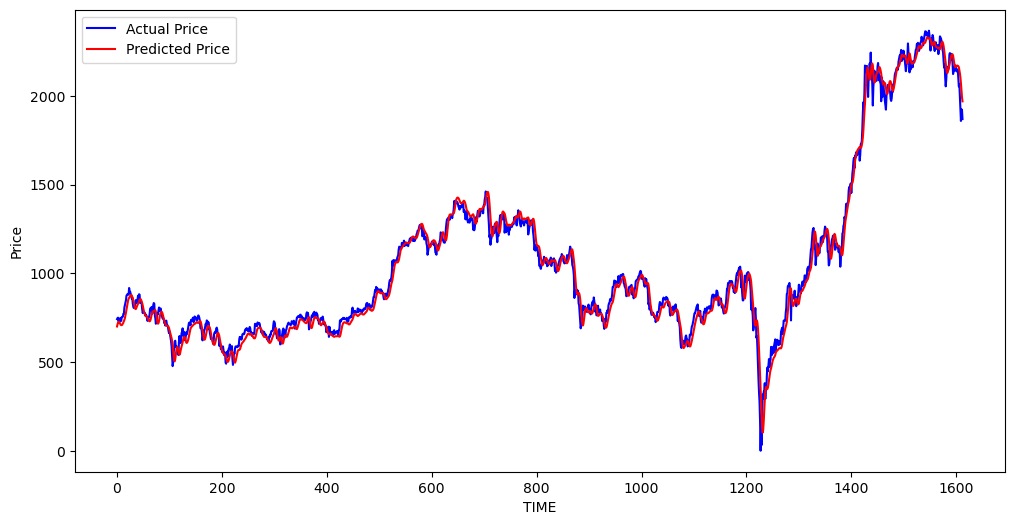

In [25]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label = 'Actual Price')
plt.plot(y_predicted, 'r', label = 'Predicted Price')
plt.xlabel('TIME')
plt.ylabel('Price')
plt.legend()
plt.show()